In [6]:
#this function is updated

def sammon(x, n = 2, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'pca'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'random'}

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """
#
#    def euclid(a,b):
#        d = np.sqrt( ((a**2).sum(axis=1)*np.ones([1,b.shape[0]]).T).T + \
#            np.ones([a.shape[0],1])*(b**2).sum(axis=1)-2*(np.dot(a,b.T)))
#        return d

    X = x

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        xD = X
    else:
        xD = cdist(X, X)

    # Remaining initialisation
    N = X.shape[0] # hmmm, shape[1]?
    scale = 0.5 / xD.sum()

    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(X)
        Y = UU[:,:n]*DD[:n] 
    else:
        Y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])

    xD = xD + np.eye(N)        
    xDinv = 1 / xD # Returns inf where D = 0.
    xDinv[np.isinf(xDinv)] = 0 # Fix by replacing inf with 0 (default Matlab behaviour).    
    yD = cdist(Y, Y) + np.eye(N)
    yDinv = 1. / yD # Returns inf where d = 0. 
    
    np.fill_diagonal(xD, 1)    
    np.fill_diagonal(yD, 1)
    np.fill_diagonal(xDinv, 0)
    np.fill_diagonal(yDinv, 0)
    
    xDinv[np.isnan(xDinv)] = 0
    yDinv[np.isnan(xDinv)] = 0
    xDinv[np.isinf(xDinv)] = 0    
    yDinv[np.isinf(yDinv)] = 0 # Fix by replacing inf with 0 (default Matlab behaviour).
    
    delta = xD - yD 
    E = ((delta**2)*xDinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = yDinv - xDinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta, Y) - (Y * deltaone)
        dinv3 = yDinv ** 3
        y2 = Y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2, Y) * np.dot(dinv3, Y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old = Y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = s.reshape(2,len(s)/2).T
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d # Returns inf where D = 0. 
            dinv[np.isinf(dinv)] = 0 # Fix by replacing inf with 0 (default Matlab behaviour).
            delta = xD - d
            E_new = ((delta**2)*xDinv).sum()
            if E_new < E:
                break
            else:
                s = np.dot(0.5,s)

        # Bomb out if too many halving steps are required
        if j == maxhalves:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if np.abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = ' + str(i) + ': E = ' + str(E * scale))

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

/Users/csstnns/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: divide by zero encountered in true_divide
/Users/csstnns/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in true_divide
/Users/csstnns/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:126: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/csstnns/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:129: RuntimeWarning: divide by zero encountered in true_divide


epoch = 0: E = 0.00321580534993
epoch = 1: E = 0.00337530884775
epoch = 2: E = 0.00321580534993
epoch = 3: E = 0.00337530884775
epoch = 4: E = 0.00321580534993
epoch = 5: E = 0.00337530884775
epoch = 6: E = 0.00321580534993
epoch = 7: E = 0.00337530884775
epoch = 8: E = 0.00321580534993
epoch = 9: E = 0.00337530884775
epoch = 10: E = 0.00321580534993
epoch = 11: E = 0.00337530884775
epoch = 12: E = 0.00321580534993
epoch = 13: E = 0.00337530884775
epoch = 14: E = 0.00321580534993
epoch = 15: E = 0.00337530884775
epoch = 16: E = 0.00321580534993
epoch = 17: E = 0.00337530884775
epoch = 18: E = 0.00321580534993
epoch = 19: E = 0.00337530884775
epoch = 20: E = 0.00321580534993
epoch = 21: E = 0.00337530884775
epoch = 22: E = 0.00321580534993
epoch = 23: E = 0.00337530884775
epoch = 24: E = 0.00321580534993
epoch = 25: E = 0.00337530884775
epoch = 26: E = 0.00321580534993
epoch = 27: E = 0.00337530884775
epoch = 28: E = 0.00321580534993
epoch = 29: E = 0.00337530884775
epoch = 30: E = 0.00

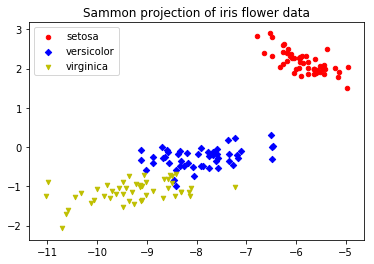

In [7]:
import numpy as np 
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline


"""Test sammon.py by plotting a projection of iris flower data. 
      Run sammontest() with no arguments.

   File        : sammontest.py
   Date        : 18 April 2014
   Author      : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)

   Description : Script to test sammon.py by applying it
   				  to Fisher's iris dataset
                 http://en.wikipedia.org/wiki/Iris_flower_data_set

   Copyright   : (c) 2014, Tom J. Pollard

   Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
   The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
   THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
   (MIT License, http://www.opensource.org/licenses/mit-license.php)

"""
# Load the iris data
iris = datasets.load_iris()
X = iris.data
target = iris.target
names = iris.target_names

# Run the Sammon projection
[y,E] = sammon(X)

   # Plot
plt.scatter(y[target ==0, 0], y[target ==0, 1], s=20, c='r', marker='o',label=names[0])
plt.scatter(y[target ==1, 0], y[target ==1, 1], s=20, c='b', marker='D',label=names[1])
plt.scatter(y[target ==2, 0], y[target ==2, 1], s=20, c='y', marker='v',label=names[2])
plt.title('Sammon projection of iris flower data')
plt.legend(loc=2)
plt.show()